**Google-colabs:** https://colab.research.google.com/drive/19TUJHL5S6dVNajnW7zqVVChRxLz7vfhv?usp=sharing

In [14]:
import os
import glob
import shutil
import random
import time

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn, optim
from PIL import Image
from torchvision.transforms import Resize
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from xfetus.xfetus import AfricanFetalPlaneDataset
from xfetus.utils import save_model, load_model, train_model, plot_training_curve, evaluate_model

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


# African Dataset

In [15]:
# !unzip /content/drive/MyDrive/FETAL_PLANES_ZENODO.zip -d /content/drive/MyDrive/fetalplane_dataset
DATA_PATH="/home/mxochicale/datasets/african-fetal-us-2023/Zenodo_dataset"
# DATA_PATH="/content/drive/MyDrive/african_dataset/Images"



## Train Model

In [16]:

DATABASE_CSV=DATA_PATH+"/African_planes_database.csv"

image_size = 224
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_train_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                                 DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="train")
african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")
print((len(african_train_dataset), len(african_val_dataset)))

(217, 233)


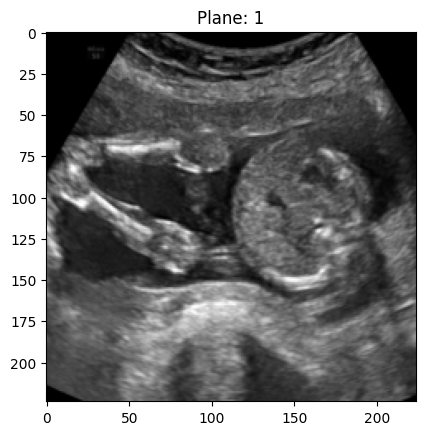

In [17]:
train_dataloader = DataLoader(african_train_dataset, batch_size=24, shuffle="True")
val_dataloader = DataLoader(african_val_dataset, batch_size=24)
ims, planes = next(iter(val_dataloader))

for i, p in list(zip(ims, planes)):
    plt.imshow(i[0], cmap="gray")
    plt.title(f"Plane: {p}")
    plt.show()
    break

In [18]:
afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(afr_model.parameters(), lr=0.001)

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# num_epochs = 100
num_epochs=3
model_save_path = DATA_PATH+'/models/afr_clf.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_ckpt.pt'

if not os.path.exists(DATA_PATH+"/models"):
    os.mkdir(DATA_PATH+"/models")

train_model(train_dataloader,
            val_dataloader,
            afr_model,
            optimizer,
            criterion,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            device,
            load_checkpoint=True)



/home/mxochicale/repositories/xfetus/xfetus/xfetus/utils.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Execution time: 0.49344515800476074s


## Train with augmentation

In [21]:
image_size = 224
transform_operations=transforms.Compose([
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(15),
                        transforms.RandomResizedCrop([image_size, image_size], (0.8, 1.0)),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Normalize((0.5), (0.5)),
                        ])
val_transforms = transform_operations=transforms.Compose([
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])


african_train_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="train")
african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=val_transforms,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")
print((len(african_train_dataset), len(african_val_dataset)))

(217, 233)


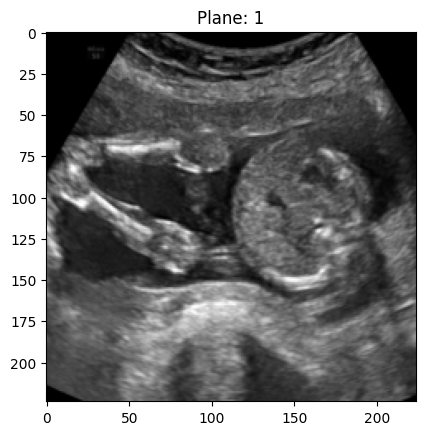

In [22]:
train_dataloader = DataLoader(african_train_dataset, batch_size=24, shuffle="True")
val_dataloader = DataLoader(african_val_dataset, batch_size=24)
ims, planes = next(iter(val_dataloader))

for i, p in list(zip(ims, planes)):
    plt.imshow(i[0], cmap="gray")
    plt.title(f"Plane: {p}")
    plt.show()
    break

In [23]:
afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(afr_model.parameters(), lr=0.001)

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
num_epochs = 3
# num_epochs = 100
# model_save_path = '/content/drive/MyDrive/xfetus/models/afr_aug_clf.pt'
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_aug_ckpt.pt'

model_save_path = DATA_PATH+'/models/afr_aug_clf.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_aug_ckpt.pt'

train_model(train_dataloader,
            val_dataloader,
            afr_model,
            optimizer,
            criterion,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            device,
            load_checkpoint=True)


/home/mxochicale/repositories/xfetus/xfetus/xfetus/utils.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Epoch 2 iteration 0 training loss: 0.008350673131644726
Epoch 2 average training loss: 0.24536296664737164, average validation loss: 0.5685862824320793
Running time: 24.126516819000244s
Execution time: 24.126566648483276s


## Train with 80/20

In [25]:
# african_dataset_csv = pd.read_csv("/content/drive/MyDrive/african_dataset/African_planes_database.csv", delimiter=",")

DATABASE_CSV=DATA_PATH+"/African_planes_database.csv"
DATABASE_CSV_8020=DATA_PATH+"/African_planes_database_8020.csv"
african_dataset_csv = pd.read_csv(DATABASE_CSV, delimiter=",")


# Using filename to give each patient an ID to split on
filename = african_dataset_csv["Filename"]
patient_id = [f.split("_plane")[0] for f in filename]
african_dataset_csv["Patient_id"] = patient_id

# Get number of train and val
train_data = african_dataset_csv.loc[african_dataset_csv['Train']==1]
val_data = african_dataset_csv.loc[african_dataset_csv['Train']==0]
train_patient_num = train_data["Patient_id"].nunique()
val_patient_num = val_data["Patient_id"].nunique()
print(f"Number of patients in train {train_patient_num}, val {val_patient_num}")

# Get values for splitting
val_split = round((train_patient_num + val_patient_num) * 0.2)
train_split = round((train_patient_num + val_patient_num) * 0.8)
print(f"For 80/20 split, number of patients in train {train_split}, val {val_split}")
num_convert = train_split - train_patient_num
print(f"Number of validation images to convert {num_convert}")

# Convert val to train
val_patient = list(val_data["Patient_id"].unique())
random.shuffle(val_patient)
for patient in val_patient[:num_convert]:
  african_dataset_csv.loc[african_dataset_csv["Patient_id"] == patient, "Train"] = 1

# Check all working correctly
new_train_data = african_dataset_csv.loc[african_dataset_csv['Train']==1]
new_val_data = african_dataset_csv.loc[african_dataset_csv['Train']==0]
new_train_patient_num = new_train_data["Patient_id"].nunique()
new_val_patient_num = new_val_data["Patient_id"].nunique()
print(f"New number of patients in train {new_train_patient_num}, val {new_val_patient_num}")

# Drop ID column to keep original columns and save
african_dataset_csv.drop(["Patient_id"], axis=1)
african_dataset_csv.to_csv(DATABASE_CSV_8020, index=False,sep=",")

Number of patients in train 61, val 66
For 80/20 split, number of patients in train 102, val 25
Number of validation images to convert 41
New number of patients in train 102, val 25


In [26]:
new_train_data["Plane"].value_counts()

Plane
Fetal abdomen    101
Fetal femur      101
Fetal brain      101
Fetal thorax      60
Name: count, dtype: int64

In [27]:
new_val_data["Plane"].value_counts()

Plane
Fetal brain      24
Fetal femur      24
Fetal abdomen    24
Fetal thorax     15
Name: count, dtype: int64

In [28]:
image_size = 224
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])


DATABASE_CSV=DATA_PATH+"/African_planes_database_8020.csv"


african_train_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="train")
african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")
print((len(african_train_dataset), len(african_val_dataset)))

# (362, 88) #original African_planes_database_8020

(363, 87)


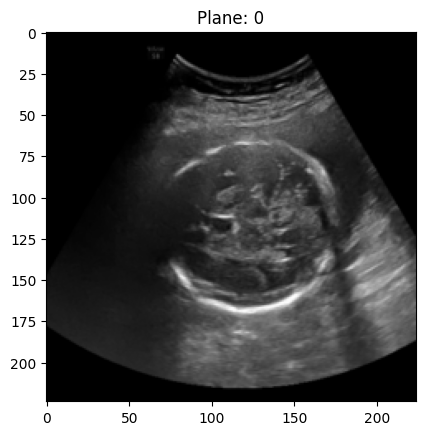

In [29]:
train_dataloader = DataLoader(african_train_dataset, batch_size=24, shuffle="True")
val_dataloader = DataLoader(african_val_dataset, batch_size=24)
ims, planes = next(iter(val_dataloader))

for i, p in list(zip(ims, planes)):
    plt.imshow(i[0], cmap="gray")
    plt.title(f"Plane: {p}")
    plt.show()
    break

In [30]:
afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(afr_model.parameters(), lr=0.001)

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
num_epochs = 3
# num_epochs = 100

# model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf_8020.pt'
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt_8020.pt'

model_save_path = DATA_PATH+'/models/afr_clf_8020.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_ckpt_8020.pt'

train_model(train_dataloader,
            val_dataloader,
            afr_model,
            optimizer,
            criterion,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            device,
            load_checkpoint=True)

/home/mxochicale/repositories/xfetus/xfetus/xfetus/utils.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Epoch 2 iteration 0 training loss: 0.1832641214132309
Epoch 2 iteration 10 training loss: 0.5264970660209656
Epoch 2 average training loss: 0.23026418848894536, average validation loss: 0.1450351607054472
Running time: 23.12831449508667s
Execution time: 23.128364324569702s


## Evaluate

In [32]:
# model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf.pt'
model_save_path = DATA_PATH+'/models/afr_clf.pt'

afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)

epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, model=afr_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")



Loaded model from best epoch 3 with validation loss: 0.21015007589012386


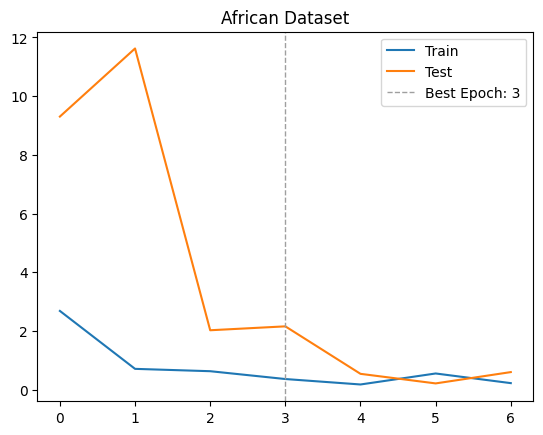

In [33]:
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_ckpt.pt'
_, _, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "African Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)


In [35]:
DATABASE_CSV=DATA_PATH+"/African_planes_database.csv"
image_size = 224

transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])
                                                 
african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")

val_dataloader = DataLoader(african_val_dataset, batch_size=8)

afr_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    # plt.imshow(inputs)
    inputs = inputs.to(device)
    outputs = afr_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))

Accuracy: 0.9484978540772532
Precision: [1.         0.953125   0.96774194 0.8372093 ]
Recall: [0.98461538 0.93846154 0.9375     0.92307692]
F1: [0.99224806 0.94573643 0.95238095 0.87804878]
Support: [65 65 64 39]


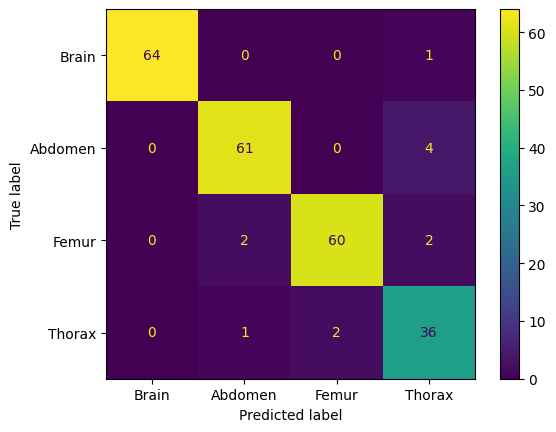

In [36]:
class_names = ["Brain", "Abdomen", "Femur", "Thorax"]
evaluate_model(label_list, pred_list, class_names)

## Evaluate with augmentation

In [37]:
# model_save_path = '/content/drive/MyDrive/xfetus/models/afr_aug_clf.pt'
model_save_path = DATA_PATH+'/models/afr_aug_clf.pt'

afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)

epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, afr_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mxochicale/repositories/xfetus/xfetus/xfetus/utils.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code

Loaded model from best epoch 2 with validation loss: 0.5685862824320793


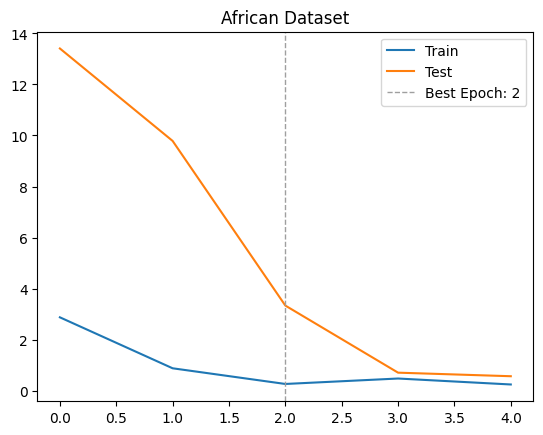

In [38]:
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_aug_ckpt.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_aug_ckpt.pt'
_, _, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "African Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)

In [39]:
image_size = 224
DATABASE_CSV=DATA_PATH+"/African_planes_database_8020.csv"

transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])



african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")

afr_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    # plt.imshow(inputs)
    inputs = inputs.to(device)
    outputs = afr_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))


Accuracy: 0.8626609442060086
Precision: [1.         0.84375    0.94827586 0.64814815]
Recall: [0.87692308 0.83076923 0.859375   0.8974359 ]
F1: [0.93442623 0.8372093  0.90163934 0.75268817]
Support: [65 65 64 39]


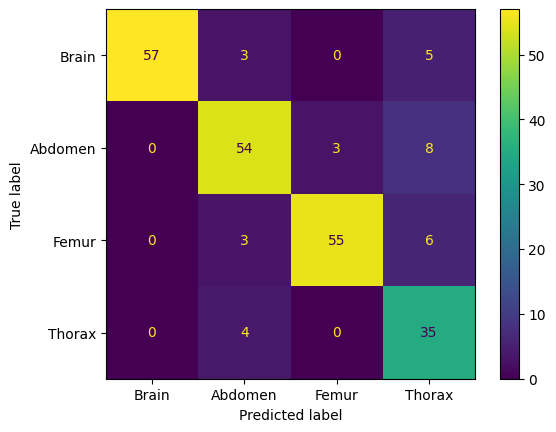

In [40]:
class_names = ["Brain", "Abdomen", "Femur", "Thorax"]
evaluate_model(label_list, pred_list, class_names)

## Evaluate 80/20

In [41]:
# model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf_8020.pt'`
model_save_path = DATA_PATH+'/models/afr_clf_8020.pt'

afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)

epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, afr_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mxochicale/repositories/xfetus/xfetus/xfetus/utils.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code

Loaded model from best epoch 2 with validation loss: 0.1450351607054472


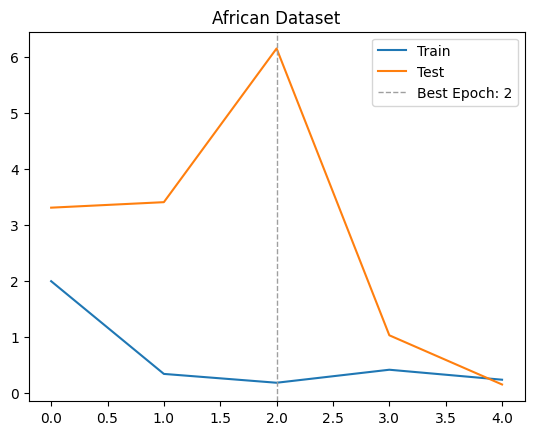

In [42]:
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt_8020.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_ckpt_8020.pt'
_, _, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "African Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)

In [43]:
# Evaluate with validation from 80/20 split
image_size = 224
DATABASE_CSV=DATA_PATH+"/African_planes_database_8020.csv"


transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")


val_dataloader = DataLoader(african_val_dataset, batch_size=8)

afr_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    # plt.imshow(inputs)
    inputs = inputs.to(device)
    outputs = afr_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))


Accuracy: 0.9540229885057471
Precision: [1.         1.         1.         0.78947368]
Recall: [0.95833333 0.875      1.         1.        ]
F1: [0.9787234  0.93333333 1.         0.88235294]
Support: [24 24 24 15]


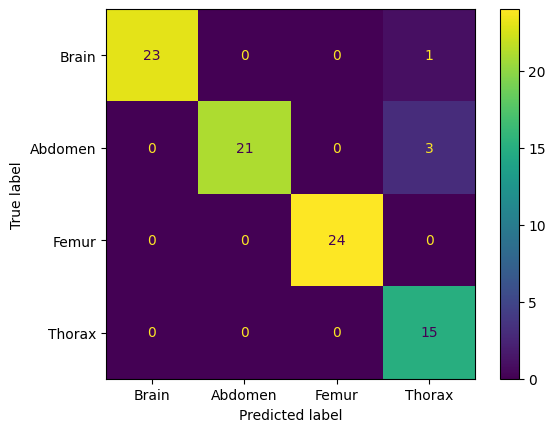

In [44]:
class_names = ["Brain", "Abdomen", "Femur", "Thorax"]
evaluate_model(label_list, pred_list, class_names)